## 🏭 Facility Location Optimization with Accelerated Gradient Descent

This notebook demonstrates the use of **Accelerated Gradient Descent (AGD)** to solve a facility location problem.
Given a set of points in 2D space, the objective is to find a location for a facility such that it lies within
a certain radius (e.g., 100 km) of as many points as possible. This is useful for placing service centers,
warehouses, or emergency response units efficiently.


### 🔄 Accelerated Gradient Descent Function

This function implements **Nesterov's Accelerated Gradient Descent** to minimize a convex objective.
It takes as input the gradient of the function, a Lipschitz constant `L`, initial point `y`, and
other optimization parameters. It returns the solution vector and number of iterations until convergence.

In [77]:
import numpy as np
import pandas as pd

def accelerated_gradient_descent(gradf, L, y, tol, maxit):
    y = np.array(y)
    rho = 0
    x = y
    for i in range(maxit):
        x_next = y - (1/L)*gradf(y,) # gradient step
        roots = np.roots([1, (1 - rho**2), -1]) # solve the quadratic equation
        rho_next = np.max(roots) # take the positive root
        beta_next=rho_next*(rho**2) # calculate the next beta
        y_next = x_next + beta_next*(x_next - x) # calculate the next y

        y = y_next
        x = x_next
        rho = rho_next

        if np.linalg.norm(gradf(y)) < tol:
            return y, i
    
    return y, maxit+1


### 📍 Facility Location Utilities

These functions support the main optimization problem:
- `count_points_in_circle`: Counts how many data points fall within a given radius from a center point.
- `plot_facility_location`: Visualizes the facility location with a surrounding circle and data points.
These are useful for evaluating and visualizing the impact of proposed facility placements.

In [89]:
import matplotlib.pyplot as plt

def count_points_in_circle(A, x, rho):
    """
    Counts the number of points in A that lie within the circle of radius rho around x.
    
    Parameters:
        A (numpy array): Matrix of points a1, a2, ..., aN (size N x 2 for 2D points).
        x (numpy array): Current facility location point (size 2).
        rho (float): Radius (e.g., 100km = 100,000 meters).
    
    Returns:
        int: Number of points inside the circle.
    """
    distances = np.linalg.norm(A - x, axis=1)  # Compute distances from each point in A to x
    count = np.sum(distances <= rho)  # Count how many points are within the radius
    return count

# Example usage to count points:



def plot_facility_location(A, x, rho):
    """
    Plots the facility location with all points in A, the facility location x,
    and a circle of radius rho around x.
    
    Parameters:
        A (numpy array): Matrix of points a1, a2, ..., aN (size N x 2 for 2D points).
        x (numpy array): Current facility location point (size 2).
        rho (float): Radius (e.g., 100km = 100,000 meters).
    """
    # Create a figure and axis using plt.subplots(), and set the figure size
    fig, ax = plt.subplots(figsize=(10, 10))  # Increase figure size to 10x10 inches
    
    # Plot all points in A as blue dots
    ax.scatter(A[:, 0], A[:, 1], color='blue', label='Data points (A)', s=5)
    
    # Plot the facility location x as a red dot
    ax.scatter(x[0], x[1], color='red', label='Facility Location (x)', s=5)
    
    # Create a circle with radius rho centered at x
    circle = plt.Circle((x[0], x[1]), rho, color='red', fill=False, linestyle='dotted', label=f'{rho/1000}km Radius')
    
    # Add the circle to the plot using add_patch
    ax.add_patch(circle)
    
    # Set axis limits based on the data to ensure all points and the circle are visible
    x_min, x_max = np.min(A[:, 0]), np.max(A[:, 0])
    y_min, y_max = np.min(A[:, 1]), np.max(A[:, 1])
    
    # Add some padding to the axis limits so that all points and the circle are fully visible
    padding_x = (x_max - x_min) * 0.1  # 10% padding for x-axis
    padding_y = (y_max - y_min) * 0.1  # 10% padding for y-axis
    
    # Set the axis limits to include all data points plus the padding
    ax.set_xlim(min(x_min, x[0] - rho) - padding_x, max(x_max, x[0] + rho) + padding_x)
    ax.set_ylim(min(y_min, x[1] - rho) - padding_y, max(y_max, x[1] + rho) + padding_y)
    
    # Set equal scaling for the axes to ensure the circle is not distorted
    ax.set_aspect('equal', adjustable='box')
    
    # Add title and legend
    ax.set_title("Facility Location with Radius")
    ax.legend(loc='best')
    
    # Set labels for x and y axes
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    
    # Add grid for better readability
    ax.grid(True)
    
    # Show the plot
    plt.show()



In [79]:
def grad_family(A, x, rho):
    # Compute the Euclidean distances from x to each point in A
    dist = np.linalg.norm(A - x, axis=1)
    
    # Compute the mask for distances greater than rho
    mask = dist > rho
    
    # Compute the gradient for points where ||x - a_i|| >= rho
    gradient = np.sum(2 * (dist[mask] - rho)[:, np.newaxis] * (x - A[mask]) / dist[mask][:, np.newaxis], axis=0)
    
    return gradient


In [95]:
def family_driver():
    A = train_data
    p = radius
    grad_func = lambda x: grad_family(A, x, p)
    y, it = accelerated_gradient_descent(gradf=grad_func, L=80000, y=[0,0],tol=20, maxit=10000 )
    plot_facility_location(A, y, radius)
    num_points_in_circle = count_points_in_circle(train_data, y, radius)
    print(f"Number of points inside the circle: {num_points_in_circle}")
    print(f"Number of iterations: {it}")
    print(f"Facility location: {y}")


In [ ]:
def huber_gradient_func(A, y, x, tau):
    Ax_minus_y = np.dot(A, x) - y
    gradient = np.where(abs(Ax_minus_y) <= tau, Ax_minus_y, np.where(Ax_minus_y > tau, tau, -tau))
    gradient_sum = np.sum(A * gradient[:, np.newaxis], axis=0)
    return gradient_sum

In [73]:
def huber_gd(A, y, x, tau, L, tol, maxit):
    """
    Huber loss function
    :param A: numpy.ndarray of shape (m, n) containing the data
        m is the number of data points
        n is the number of features
    :param y: numpy.ndarray of shape (m,) containing the correct labels
    :param x: numpy.ndarray of shape (n,) containing the initial weights
    :param tau: the maximum step size
    :param L: the Lipschitz constant of the function
    :param tol: the maximum tolerance for the result
    :param maxit: the maximum number of iterations
    :return: the optimal weight and the list of all the partial weights
    """
    A = np.column_stack((np.ones(len(A)), A))
    for i in range(maxit):
        if i % 100000 == 0:
            print(f'Iteration: {i} Weights: {x}')
        grad_huber = huber_gradient_func(A, y, x, tau)
        if np.linalg.norm(grad_huber) < tol:
            return x, i
        else:
            x = x - (1 / L) * grad_huber
    
    return x, maxit
        

In [105]:
def huber_driver():
    df = pd.read_csv('data.csv')
    df_data = df.copy()
    df_data['Period'] = df_data.index.values + 1
    even_rows = df_data[df_data.index % 2 == 0]
    odd_rows = df_data[df_data.index % 2 != 0]
    A= list(df_data['Period'])
    A_train = list(odd_rows['Period'])
    A_train = np.column_stack((np.ones(len(A_train)), A_train))
    y_train = list(odd_rows['Scheduled'])
    A_test = list(even_rows['Period'])
    y_test = list(even_rows['Scheduled'])
    tau = 25000

    grad_func = lambda x: huber_gradient_func(A_train, y_train, x, tau)
    w, it = accelerated_gradient_descent(gradf=grad_func, L=4.28e6, y=np.array([0, 0]),tol=5000, maxit=1000000)
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ax.scatter(df_data['Period'], df_data['Scheduled'], label='Actual', s=6)
    ax.plot(df_data['Period'], np.dot(np.column_stack((np.ones(len(df_data)), df_data['Period'])), w), color='green', label='Huber Regression')
    plt.show()
    print(f"Number of iterations: {it}")

    


In [64]:
def norm_residuals(A, y, weights):
    A = np.column_stack((np.ones(len(A)), A))
    residuals = np.dot(A, weights)-y
    return np.linalg.norm(residuals)

In [67]:
def error_rate(A, y, weights):
    A = np.column_stack((np.ones(len(A)), A))
    residuals = np.dot(A, weights)-y
    errors = np.abs(residuals) <50000
    return f"{errors.sum()}/{len(errors)}"

In [80]:
df = pd.read_csv('census_2021_extract.csv', header=None)
df = df[[2,3]]

In [81]:
train_data = df.to_numpy()
radius = 100000

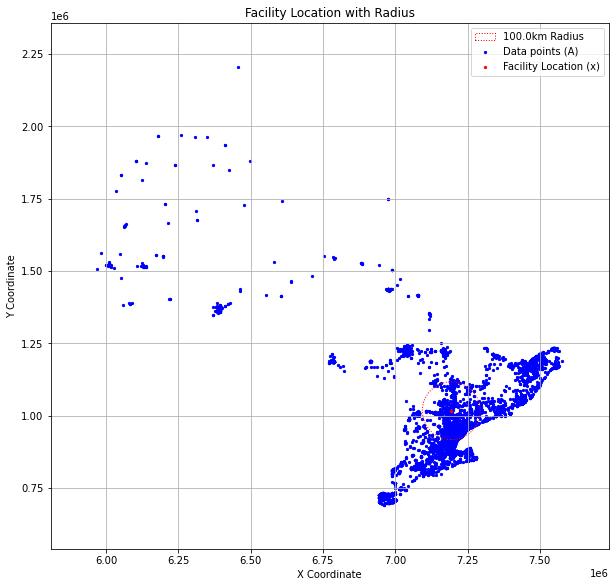

Number of points inside the circle: 10270
Number of iterations: 157
Facility location: [7193725.22471926 1016738.22622094]


In [96]:
family_driver()

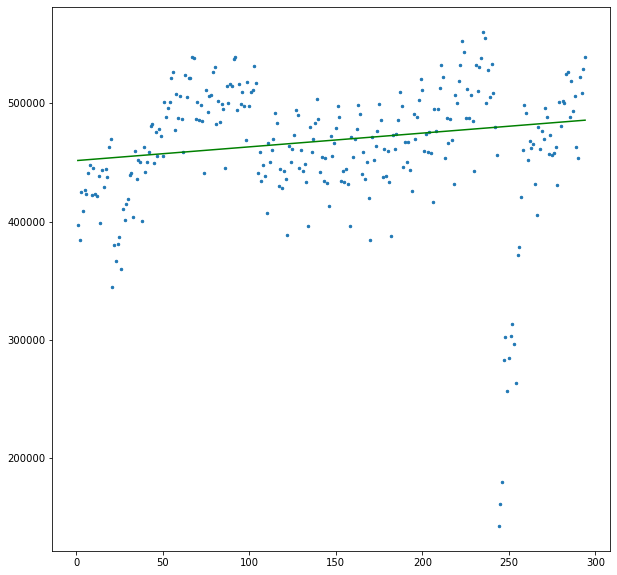

Number of iterations: 3318


In [106]:
huber_driver()

In [5]:
A_train = np.array(A_train)

In [6]:
df_data['Period'] = df_data.index.values + 1

In [55]:
even_rows = df_data[df_data.index % 2 == 0]
odd_rows = df_data[df_data.index % 2 != 0]


In [56]:
A= list(df_data['Period'])

In [58]:
A_train = list(odd_rows['Period'])
y_train = list(odd_rows['Scheduled'])
A_test = list(even_rows['Period'])
y_test = list(even_rows['Scheduled'])

In [59]:
weights_linear = linear_regression(A_train, y_train)

In [60]:
weights_huber = huber_gd(A_train, y_train, np.array([0, 0]), 25000, 4.28e6, 5000, 10**7)

Iteration: 0 Weights: [0 0]
Iteration: 10000 Weights: [3468.08064628 2325.6452417 ]
Iteration: 20000 Weights: [6925.54111609 2309.25526965]
Iteration: 30000 Weights: [10381.79112087  2292.73546521]
Iteration: 40000 Weights: [13836.70143476  2276.22206408]
Iteration: 50000 Weights: [17290.27257705  2259.71506377]
Iteration: 60000 Weights: [20742.50506681  2243.21446181]
Iteration: 70000 Weights: [24193.39942294  2226.72025571]
Iteration: 80000 Weights: [27642.91686633  2210.36584661]
Iteration: 90000 Weights: [31090.90500446  2194.11273859]
Iteration: 100000 Weights: [34537.34520363  2177.88751663]
Iteration: 110000 Weights: [37982.16545606  2161.7599916 ]
Iteration: 120000 Weights: [41425.32006973  2145.60807538]
Iteration: 130000 Weights: [44866.70172339  2129.40299818]
Iteration: 140000 Weights: [48306.27961129  2113.20641471]
Iteration: 150000 Weights: [51744.05467884  2097.01832052]
Iteration: 160000 Weights: [55180.02787097  2080.83871115]
Iteration: 170000 Weights: [58614.2008079

In [62]:
iterations  = weights_huber[1]
weights_huber  = weights_huber[0]

In [65]:
residuals_linear = norm_residuals(A_test, y_test, weights_linear)
residuals_huber = norm_residuals(A_test, y_test, weights_huber)

In [66]:
residuals_linear, residuals_huber, iterations

(661985.6964520344, 669942.8508987797, 2681260)

In [68]:
error_linear = error_rate(A_test, y_test, weights_linear)
error_huber = error_rate(A_test, y_test, weights_huber)

In [69]:
error_linear, error_huber

('115/147', '117/147')

In [70]:
error_huber

'117/147'

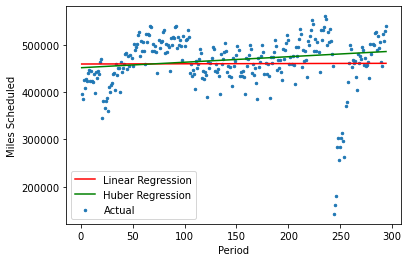

In [72]:
import matplotlib.pyplot as plt

# Plotting the original data
plt.scatter(df_data['Period'], df_data['Scheduled'], label='Actual', s=6)

# Plotting the predicted values using weights_linear
plt.plot(df_data['Period'], np.dot(np.column_stack((np.ones(len(df_data)), df_data['Period'])), weights_linear), color='red', label='Linear Regression')

# Plotting the predicted values using weights_huber
plt.plot(df_data['Period'], np.dot(np.column_stack((np.ones(len(df_data)), df_data['Period'])), weights_huber), color='green', label='Huber Regression')

plt.xlabel('Period')
plt.ylabel('Miles Scheduled')
plt.legend()
plt.show()


Iteration: 0 Weights: [0 0]
Iteration: 100000 Weights: [34537.34520363  2177.88751663]
Iteration: 200000 Weights: [68907.46554847  2016.590117  ]
Iteration: 300000 Weights: [103119.54447166   1856.70069415]
Iteration: 400000 Weights: [137158.50616302   1696.33339113]
Iteration: 500000 Weights: [170957.44734919   1533.3932294 ]
Iteration: 600000 Weights: [204347.74884677   1369.29849984]
Iteration: 700000 Weights: [237228.57039571   1204.52541676]
Iteration: 800000 Weights: [269537.31908175   1040.18898194]
Iteration: 900000 Weights: [301189.33805734    877.44727346]
Iteration: 1000000 Weights: [331813.30794431    724.35151806]
Iteration: 1100000 Weights: [360446.82105128    580.88935922]
Iteration: 1200000 Weights: [384911.10452515    459.5282521 ]
Iteration: 1300000 Weights: [4.04242820e+05 3.62055427e+02]
Iteration: 1400000 Weights: [4.18623473e+05 2.87905857e+02]
Iteration: 1500000 Weights: [4.28873713e+05 2.34663687e+02]
Iteration: 1600000 Weights: [4.35900287e+05 1.98091470e+02]
I

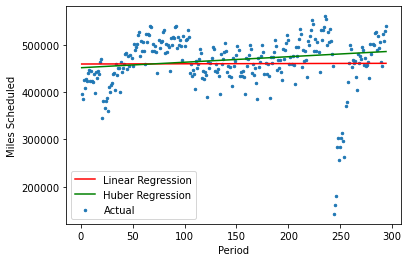

In [74]:
df = pd.read_csv('data.csv')
df_data = df.copy()
df_data['Period'] = df_data.index.values + 1
even_rows = df_data[df_data.index % 2 == 0]
odd_rows = df_data[df_data.index % 2 != 0]
A= list(df_data['Period'])
A_train = list(odd_rows['Period'])
y_train = list(odd_rows['Scheduled'])
A_test = list(even_rows['Period'])
y_test = list(even_rows['Scheduled'])
weights_linear = linear_regression(A_train, y_train)
weights_huber = huber_gd(A_train, y_train, np.array([0, 0]), 25000, 4.28e6, 5000, 10**7)
iterations  = weights_huber[1]
weights_huber  = weights_huber[0]
residuals_linear = norm_residuals(A_test, y_test, weights_linear)
residuals_huber = norm_residuals(A_test, y_test, weights_huber)

print(f'Linear Regression residuals: {residuals_linear}')
print(f'Huber Regression residuals: {residuals_huber}')
print(f'Huber Regression iterations: {iterations}')


error_linear = error_rate(A_test, y_test, weights_linear)
error_huber = error_rate(A_test, y_test, weights_huber)

print(f'Linear Regression error rate: {error_linear}')
print(f'Huber Regression error rate: {error_huber}')

# Plotting the original data
plt.scatter(df_data['Period'], df_data['Scheduled'], label='Actual', s=6)

# Plotting the predicted values using weights_linear
plt.plot(df_data['Period'], np.dot(np.column_stack((np.ones(len(df_data)), df_data['Period'])), weights_linear), color='red', label='Linear Regression')

# Plotting the predicted values using weights_huber
plt.plot(df_data['Period'], np.dot(np.column_stack((np.ones(len(df_data)), df_data['Period'])), weights_huber), color='green', label='Huber Regression')

plt.xlabel('Period')
plt.ylabel('Miles Scheduled')
plt.legend()
plt.show()